In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

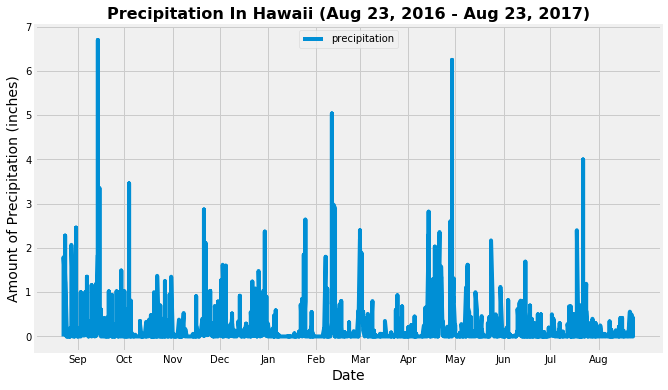

In [10]:

############################################################################################################
# Design a query to retrieve the last 12 months of precipitation data and plot the results
############################################################################################################
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(func.max(Measurement.date)).scalar() #'2017-08-23'
date_one_yr_ago_dt = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365) #'2016-08-23'
date_one_yr_ago = date_one_yr_ago_dt.strftime('%Y-%m-%d')
                                       
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date.between(date_one_yr_ago, last_date),\
              Measurement.prcp != None).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_yr_precip_df = pd.DataFrame(results).set_index('date')

# Sort the dataframe by date
df2 = last_yr_precip_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,6))
plt.plot(df2.index, df2['prcp'])
plt.legend(['precipitation'], loc='upper center')
xloc = ['2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',\
    '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01']
plt.xticks(xloc, ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug'])
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Amount of Precipitation (inches)', fontsize = 14)
plt.title('Precipitation In Hawaii (Aug 23, 2016 - Aug 23, 2017)', fontweight = 'bold', fontsize = 16)
plt.savefig('precipitation.png', bbox_inches="tight", dpi=199)
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
df2.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
locations = session.query(func.count(Station.station)).all()
print("There are {} stations available.".format(locations[0][0]))

There are 9 stations available.


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_station=engine.execute("SELECT station,count(station) FROM measurement GROUP BY station ORDER BY count(station) DESC").fetchall()
most_active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), \
              func.avg(Measurement.tobs)).\
        filter(Measurement.station == most_active_station[0][0]).all()
print ("Lowest Temperature: {}".format(data[0][0]))
print ("Highest Temperature: {}".format(data[0][1]))
print ("Average Temperature: {}".format(data[0][2]))

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


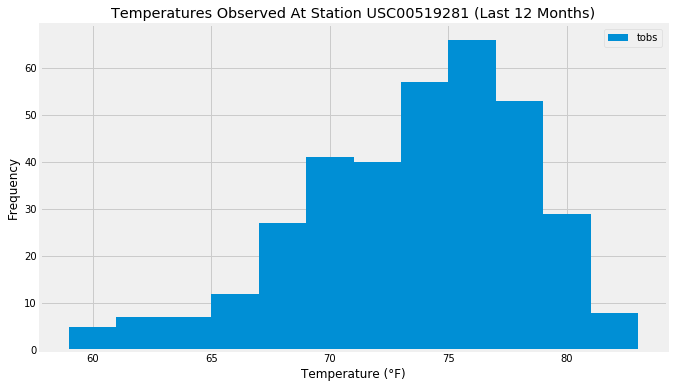

In [21]:
# Choose the station with the highest number of temperature observations.
session.query(Measurement.station, func.count(Measurement.tobs)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.tobs).desc()).first() # 'USC00519281'

# Query the last 12 months of temperature observation data for this station
results = session.query(Measurement.tobs).\
            filter(Measurement.date.between(date_one_yr_ago, last_date),\
                   Measurement.station == 'USC00519281').all()

# Plot the results as a histogram
plt.figure(figsize=(10,6))
plt.hist(np.ravel(results), bins=12)
plt.title('Temperatures Observed At Station USC00519281 (Last 12 Months)')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.legend(['tobs'], loc = 'upper right')
plt.show()

![precipitation](Images/station-histogram.png)

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-08-23', '2017-08-23'))

[(58.0, 74.59058295964125, 87.0)]


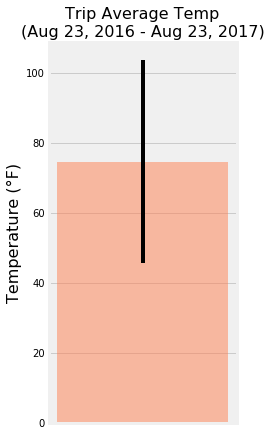

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin, avg, tmax = calc_temps('2016-08-23', '2017-08-23')[0]
plt.figure(figsize=(3,7))
plt.bar([0], avg, yerr = tmax-tmin, color = 'coral', alpha = 0.5)
plt.title('Trip Average Temp\n(Aug 23, 2016 - Aug 23, 2017)', fontsize = 16)
plt.xticks([])
plt.ylabel('Temperature (°F)', fontsize = 16)
plt.show()

In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
results = session.query(Measurement.station, Station.name, Station.latitude,\
              Station.longitude, Station.elevation, func.avg(Measurement.prcp)).\
        filter(Measurement.station == Station.station,\
               Measurement.date.between(date_one_yr_ago, last_date)).\
        group_by(Measurement.station).\
        order_by(Measurement.prcp.desc()).\
        all()

print(results)


[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.19894886363636372), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.45064024390243923), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.14142857142857151), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.12543396226415093), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.12105095541401273), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.044818941504178235), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0765)]


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
